# Agents and Tools

In [1]:
import tomli, os
with open("../.streamlit/secrets.toml","rb") as f:
    secrets = tomli.load(f)
os.environ["OPENAI_API_KEY"] = secrets["OPENAI_API_KEY"]
os.environ["SERPAPI_API_KEY"] = secrets["SERPAPI_API_KEY"]

## Smith: Simple mini independent tool handler

In [4]:
import importlib
smith = importlib.import_module('smith')
importlib.reload(smith)

<module 'smith' from 'c:\\Users\\ydebray\\Downloads\\gpt-programming-book\\chap5\\smith.py'>

In [5]:
from smith import *

In [9]:
prompt = 'Who is the CEO of Twitter?'
print(agent(prompt)) # Calling agent without passing tools

As of September 2021, the CEO of Twitter is Jack Dorsey.


In [68]:
tools = load_tools()
tools

[{'name': 'search',
  'desc': 'Useful for when you need to answer questions about current events.',
  'example': 'What movie won best picture in 2023?'},
 {'name': 'python',
  'desc': 'Useful for when performing computing and trying to solve mathematical problems',
  'example': 'What is the 10th element of the Fibonacci suite'}]

In [69]:
prompt = 'Who is the CEO of Twitter?'
res = agent(prompt,tools=tools)
print(res)

tool: search
------------------
The CEO of Twitter is Linda Yaccarino, as reported by The Verge.


Breaking down the tool choice and execution.

In [70]:
prompt = 'What movie won best picture in 2024?'
pick_tool(prompt,tools)

'search'

In [71]:
res = search_tool(prompt)
print(res)

Answer the user request given the following information retrieved from an internet search:
  Oppenheimer
  


In [72]:
prompt = 'What is the square root of 42?'
# res = pick_tool(prompt,tools)
res = agent(prompt,tools=tools)
print(res)

tool: python
------------------
import math

result = math.sqrt(42)
print(result)


## LangChain agents

In [59]:
from langchain.agents import load_tools, initialize_agent, AgentType
from langchain_openai import ChatOpenAI
# Load the model
llm = ChatOpenAI(temperature=0)
# Load in some tools to use
tools = load_tools(["serpapi"])
# Finally, let's initialize an agent with:
# 1. The tools
# 2. The language model
# 3. The type of agent we want to use.

agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)
# Now let's test it out!
agent.run("who is the ceo of twitter?")



> Entering new AgentExecutor chain...
I should search for the current CEO of Twitter.
Action: Search
Action Input: "current CEO of Twitter"
Observation: Linda Yaccarino
Thought:That doesn't seem right, I should search again.
Action: Search
Action Input: "current CEO of Twitter 2021"
Observation: Parag Agrawal
Thought:Parag Agrawal is the current CEO of Twitter.
Final Answer: Parag Agrawal

> Finished chain.


'Parag Agrawal'

It seems like the agent is getting the date wrong.
Let's create our own tool to handle the date.

In [57]:
from langchain.agents import tool
from datetime import date

In [58]:
# Define a tool that returns the current date
@tool
def time(text: str) -> str:
    """Returns todays date, use this for any \
    questions related to knowing todays date. \
    The input should always be an empty string, \
    and this function will always return todays \
    date - any date mathmatics should occur \
    outside this function."""
    return str(date.today())

In [60]:
agent= initialize_agent(
    tools + [time], 
    llm, 
    agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True,
    verbose = True)

In [61]:
try:
    result = agent("whats the date today?") 
except: 
    print("exception on external access")

c:\Users\ydebray\Downloads\gpt-programming-book\env\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new AgentExecutor chain...
Thought: I should use the `time` tool to find out today's date.

Action:
```
{
  "action": "time",
  "action_input": ""
}
```


Observation: 2024-05-04
Thought:Final Answer: 2024-05-04

> Finished chain.


In [65]:
agent("who is the CEO of twitter today? (First get the date and then answer)")



> Entering new AgentExecutor chain...
Thought: Let's first find out today's date and then search for the current CEO of Twitter. 

Action:
```
{
  "action": "time",
  "action_input": ""
}
```
Observation: 2024-05-04
Thought:Now that we have today's date, let's search for the current CEO of Twitter. 

Action:
```
{
  "action": "Search",
  "action_input": "current CEO of Twitter 2024"
}
```
Observation: Linda Yaccarino
Thought:Final Answer: Linda Yaccarino

> Finished chain.


{'input': 'As of today, who is the CEO of twitter? (First get the date and then ask the question.)',
 'output': 'Linda Yaccarino'}

Another tool for search: DuckDuckGo

`pip install duckduckgo_search`

In [7]:
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()
res = search.run("CEO of Twitter")

'Twitter framed a copy of one of her motivational tweets about "wearing 4 inch heels" while working as an executive and hung it in a dining common area in the San Francisco office. She has also ... FILE - Twitter CEO Elon Musk, center, speaks with Linda Yaccarino, chairman of global advertising and partnerships for NBC, at the POSSIBLE marketing conference, Tuesday, April 18, 2023, in Miami Beach, Fla. Musk announced Friday, May 12, 2023, that he\'s hiring Yaccarino to be the new CEO of San Francisco-based Twitter, which is now called X Corp. (AP Photo/Rebecca Blackwell, File) Updated on: May 15, 2023 / 9:49 AM EDT / MoneyWatch. Elon Musk has tapped Linda Yaccarino, until this week the head of advertising at NBCUniversal, to replace him as CEO of Twitter, he announced ... David Becker/Getty Images. Jack Dorsey cofounded Twitter in 2006 and the company made him a billionaire. He stepped down as Twitter CEO in 2021 and supported Elon Musk\'s takeover of the company ... Jack Dorsey is the

c:\Users\ydebray\Downloads\gpt-programming-book\env\lib\site-packages\curl_cffi\aio.py:204: UserWarning: Curlm alread closed! quitting from process_data
  warnings.warn("Curlm alread closed! quitting from process_data")


## OpenAI Functions

- [OpenAI Blog function calling](https://openai.com/blog/function-calling-and-other-api-updates)
- [OpenAI Doc function calling](https://platform.openai.com/docs/guides/gpt/function-calling)
- [How_to_call_functions_with_chat_models.ipynb](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_call_functions_with_chat_models.ipynb)
- [How_to_call_functions_for_knowledge_retrieval.ipynb](https://github.com/openai/openai-cookbook/blob/0d1436b8d9b858c220d708a446a09eef54be61b0/examples/How_to_call_functions_for_knowledge_retrieval.ipynb)

In [29]:
import tomli, openai, json
with open('../.streamlit/secrets.toml','rb') as f:
    toml_dict = tomli.load(f)
openai.api_key = toml_dict['OPENAI_API_KEY']

In [10]:
# Example dummy function hard coded to return the same weather
# In production, this could be your backend API or an external API
def get_current_weather(location, unit="fahrenheit"):
    """Get the current weather in a given location"""
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)

In [48]:
import os
functions_list = os.listdir("functions")
functions_list

['get_current_weather.json']

In [53]:
functions = []
with open("functions/get_current_weather.json", "r") as f:
    functions.append(json.loads(f.read()))
functions

[{'name': 'get_current_weather',
  'description': 'Get the current weather in a given location',
  'parameters': {'type': 'object',
   'properties': {'location': {'type': 'string',
     'description': 'The city and state, e.g. San Francisco, CA'},
    'unit': {'type': 'string', 'enum': ['celsius', 'fahrenheit']}},
   'required': ['location']}}]

In [54]:
# Step 1: send the conversation and available functions to GPT
messages = [{"role": "user", "content": "What's the weather like in Boston?"}]
response = openai.chat.completions.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
    functions=functions,
    function_call="auto",  # auto is default, but we'll be explicit
)
response_message = response.choices[0].message
dict(response_message)

{'content': None,
 'role': 'assistant',
 'function_call': FunctionCall(arguments='{\n  "location": "Boston, MA"\n}', name='get_current_weather'),
 'tool_calls': None}

In [55]:
# Step 2: check if GPT wanted to call a function, and call it
if response_message.function_call is not None:
    # Note: the JSON response may not always be valid; be sure to handle errors
    available_functions = {
        "get_current_weather": get_current_weather,
    }  # only one function in this example, but you can have multiple
    function_name = response_message.function_call.name
    function_to_call = available_functions[function_name]
    function_args = json.loads(response_message.function_call.arguments)
    function_response = function_to_call(
        location=function_args.get("location"),
        unit=function_args.get("unit"),
    )
function_response

'{"location": "Boston, MA", "temperature": "72", "unit": null, "forecast": ["sunny", "windy"]}'

In [34]:
# Step 3: send the info on the function call and function response to GPT
messages.append(response_message)  # extend conversation with assistant's reply
messages.append(
    {
        "role": "function",
        "name": function_name,
        "content": function_response,
    }
)  # extend conversation with function response
second_response = openai.chat.completions.create(
    model="gpt-3.5-turbo-0613",
    messages=messages,
)  # get a new response from GPT where it can see the function response
second_response.choices[0].message.content

'The current weather in Boston is sunny and windy with a temperature of 72 degrees.'

## OpenAI Assistants

- [Assistant overview](https://platform.openai.com/docs/assistants/overview)

### Step 1: Create an Assistant

An [Assistant](https://platform.openai.com/docs/api-reference/assistants/object) represents an entity that can be configured to respond to a user's messages using several parameters like `model`, `instructions`, and `tools`.

In [72]:
from openai import OpenAI
client = OpenAI()
# Step 1: create an assistant
assistant = client.beta.assistants.create(
  name="Math Tutor",
  instructions="You are a personal math tutor. Write and run code to answer math questions.",
  tools=[{"type": "code_interpreter"}],
  model="gpt-4-turbo",
)

In [73]:
print("id:", assistant.id)
print("Name:", assistant.name)
print("Model:", assistant.model)
print("Tools:", [t.type for t in assistant.tools])

id: asst_RjI8kOYWuIa8t6DXPlembrrW
Name: Math Tutor
Model: gpt-4-turbo
Tools: ['code_interpreter']


### Step 2: Create a Thread

A [Thread](https://platform.openai.com/docs/api-reference/threads/object) represents a conversation between a user and one or many Assistants. You can create a Thread when a user (or your AI application) starts a conversation with your Assistant.

In [74]:
# Step 2: create a thread
thread = client.beta.threads.create()

In [75]:
thread.id

'thread_4RO03JN9aTWIEoJ78rLhuuxW'

In [82]:
from datetime import datetime
datetime.fromtimestamp(assistant.created_at).strftime('%Y-%m-%d %H:%M:%S')

'2024-05-05 10:47:07'

### Step 3: Add a Message to the Thread

The contents of the messages your users or applications create are added as [Message](https://platform.openai.com/docs/api-reference/messages/object) objects to the Thread. Messages can contain both text and files. There is no limit to the number of Messages you can add to Threads — we smartly truncate any context that does not fit into the model's context window.

In [77]:
# Step 3: Add a Message to the Thread
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="I need to solve the equation `3x + 11 = 14`. Can you help me?"
)

In [87]:
message.content[0].text.value

'I need to solve the equation `3x + 11 = 14`. Can you help me?'

### Step 4: Create a Run

Once all the user Messages have been added to the Thread, you can [Run](https://platform.openai.com/docs/api-reference/runs/object) the Thread with any Assistant. Creating a Run uses the model and tools associated with the Assistant to generate a response. These responses are added to the Thread as assistant Messages.

- **Without streaming**:
Runs are asynchronous, which means you'll want to monitor their status by polling the Run object until a terminal status is reached. For convenience, the 'create and poll' SDK helpers assist both in creating the run and then polling for its completion.
- **With streaming**:
You can use the 'create and stream' helpers in the Python and Node SDKs to create a run and stream the response.

In [79]:
# Step 4: Create a Run (without streaming)
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=assistant.id,
)
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages.data[0].content[0].text.value)

The solution to the equation \(3x + 11 = 14\) is \(x = 1\).


### Run lifecycle

You may also want to list the [Run Steps](https://platform.openai.com/docs/api-reference/run-steps/listRunSteps) if you'd like to look at any tool calls made during this Run.

In [81]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id,
    run_id=run.id
)

for d in run_steps.data:
    print("Type: ",d.step_details.type)
    if d.step_details.type == 'message_creation':
        i = d.step_details.message_creation.message_id
        m = client.beta.threads.messages.retrieve(
            thread_id=thread.id,
            message_id=i
        )
        print(m.content[0].text.value)
    elif d.step_details.type == 'tool_calls':
        print(d.step_details.tool_calls[0].code_interpreter.input)
    print("------")

Type:  message_creation
The solution to the equation \(3x + 11 = 14\) is \(x = 1\).
------
Type:  tool_calls
from sympy import symbols, Eq, solve

x = symbols('x')
equation = Eq(3*x + 11, 14)
solution = solve(equation, x)
solution
------
Type:  message_creation
Sure, I can help you solve the equation \(3x + 11 = 14\).

Let's start by isolating \(x\) on one side of the equation.
------


## Passing files to Code Interpreter: meet the Data Analyst

Demo with the Titanic dataset.

https://www.kaggle.com/c/titanic/data

In [2]:
from openai import OpenAI
client = OpenAI()
analyst = client.beta.assistants.create(
  name="Data Analyst",
  instructions="You are a data analyst. When asked a question, write and run code to answer the question.",
  model="gpt-4-turbo",
  tools=[{"type": "code_interpreter"}]
)

In [3]:
# Upload a file with an "assistants" purpose
file = client.files.create(
  file=open("titanic.csv", "rb"),
  purpose='assistants'
)

In [11]:
file.id

'file-vSBcoeH1Z8jQjWj87LPgkecl'

In [29]:
thread = client.beta.threads.create()
message = client.beta.threads.messages.create(
  thread_id=thread.id,
  role="user",
  content="What is the average age of passengers on the Titanic?",
  attachments=[
    {
      "file_id": file.id,
      "tools": [{"type": "code_interpreter"}]
    }
  ]
)

In [30]:
run = client.beta.threads.runs.create_and_poll(
  thread_id=thread.id,
  assistant_id=analyst.id,
)
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(
    thread_id=thread.id
  )
  print(messages.data[0].content[0].text.value)

The average age of passengers on the Titanic was approximately 29.7 years.


In [31]:
# Inspect the chain of thoughts
for m in messages.data[::-1]:
    # Print message content in reversed order as they pile up
    print(m.content[0].text.value)

What is the average age of passengers on the Titanic?
To calculate the average age of the passengers on the Titanic, I'll first need to load and inspect the dataset to locate the appropriate column for age. Let's start by reading the data.
The dataset has a column named 'Age' that contains the ages of the passengers. Let's calculate the average age of the passengers using this column.
The average age of passengers on the Titanic was approximately 29.7 years.


In [32]:
run_steps = client.beta.threads.runs.steps.list(
    thread_id=thread.id,
    run_id=run.id
)
# Extract only the code interpreter input
for d in run_steps.data[::-1]:
    if d.step_details.type == 'tool_calls':
        print(d.step_details.tool_calls[0].code_interpreter.input)

import pandas as pd

# Load the data from the uploaded file
file_path = '/mnt/data/file-vSBcoeH1Z8jQjWj87LPgkecl'
data = pd.read_csv(file_path)

# Show a sample of the data and the column names
data.head(), data.columns
# Calculate the average age of the passengers
average_age = data['Age'].mean()
average_age


In [33]:
code = [d.step_details.tool_calls[0].code_interpreter.input for d in run_steps.data[::-1] if d.step_details.type == 'tool_calls']
code

["import pandas as pd\r\n\r\n# Load the data from the uploaded file\r\nfile_path = '/mnt/data/file-vSBcoeH1Z8jQjWj87LPgkecl'\r\ndata = pd.read_csv(file_path)\r\n\r\n# Show a sample of the data and the column names\r\ndata.head(), data.columns",
 "# Calculate the average age of the passengers\naverage_age = data['Age'].mean()\naverage_age"]

### Reading images and files generated by Code Interpreter

ChatGPT interpreter plugin demo

In [ ]:
# List existing assistants
assistants = client.beta.assistants.list()
assistants.data

[Assistant(id='asst_somL5t4D3BKYer05lZgcmdY3', created_at=1714946510, description=None, instructions='You are a data analyst. When asked a question, write and run code to answer the question.', metadata={}, model='gpt-4-turbo', name='Data Analyst', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0),
 Assistant(id='asst_RjI8kOYWuIa8t6DXPlembrrW', created_at=1714920427, description=None, instructions='You are a personal math tutor. Write and run code to answer math questions.', metadata={}, model='gpt-4-turbo', name='Math Tutor', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0),
 Assistant(id='asst_ugQ1zfKNdgR0PoprIRi7IdqO', c

In [39]:
# Retrieve data analyst
analyst_id = 'asst_somL5t4D3BKYer05lZgcmdY3'
client.beta.assistants.retrieve(analyst_id)

Assistant(id='asst_somL5t4D3BKYer05lZgcmdY3', created_at=1714946510, description=None, instructions='You are a data analyst. When asked a question, write and run code to answer the question.', metadata={}, model='gpt-4-turbo', name='Data Analyst', object='assistant', tools=[CodeInterpreterTool(type='code_interpreter')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None), top_p=1.0)

In [37]:
prompts = [
    "plot function 1/sin(x)",
    "zoom in to range of x values between 0 and 1",
    "plot a tangent line to the graph at x=0.3",
    "zoom in to the point of tangency"
]

In [38]:
# Create a new thread
thread = client.beta.threads.create()
message = client.beta.threads.messages.create(
  thread_id=thread.id, role="user", content=prompts[0])

In [40]:
run = client.beta.threads.runs.create_and_poll(thread_id=thread.id,assistant_id=analyst_id,)
if run.status == 'completed': 
  messages = client.beta.threads.messages.list(thread_id=thread.id)
messages.data[0]

Message(id='msg_QhJN8P6cZJSZgidYNyjwdkwe', assistant_id='asst_somL5t4D3BKYer05lZgcmdY3', attachments=[], completed_at=None, content=[ImageFileContentBlock(image_file=ImageFile(file_id='file-8UVyWuiKqB3ALtIF0h8sAewt'), type='image_file'), TextContentBlock(text=Text(annotations=[], value="Here is the plot of the function \\(\\frac{1}{\\sin(x)}\\) over the range from \\(-2\\pi\\) to \\(2\\pi\\). I've limited the y-axis to the range \\([-10, 10]\\) to keep the plot visually informative, especially around values where the sine function approaches zero and the function \\(\\frac{1}{\\sin(x)}\\) approaches infinity."), type='text')], created_at=1714948943, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_tO0e1vGKvMHAU86kvB5LKoom', status=None, thread_id='thread_iHrMsStk78Sz80CL9KCdhVvh')

In [41]:
dict(messages.data[0])

{'id': 'msg_QhJN8P6cZJSZgidYNyjwdkwe',
 'assistant_id': 'asst_somL5t4D3BKYer05lZgcmdY3',
 'attachments': [],
 'completed_at': None,
 'content': [ImageFileContentBlock(image_file=ImageFile(file_id='file-8UVyWuiKqB3ALtIF0h8sAewt'), type='image_file'),
  TextContentBlock(text=Text(annotations=[], value="Here is the plot of the function \\(\\frac{1}{\\sin(x)}\\) over the range from \\(-2\\pi\\) to \\(2\\pi\\). I've limited the y-axis to the range \\([-10, 10]\\) to keep the plot visually informative, especially around values where the sine function approaches zero and the function \\(\\frac{1}{\\sin(x)}\\) approaches infinity."), type='text')],
 'created_at': 1714948943,
 'incomplete_at': None,
 'incomplete_details': None,
 'metadata': {},
 'object': 'thread.message',
 'role': 'assistant',
 'run_id': 'run_tO0e1vGKvMHAU86kvB5LKoom',
 'status': None,
 'thread_id': 'thread_iHrMsStk78Sz80CL9KCdhVvh'}

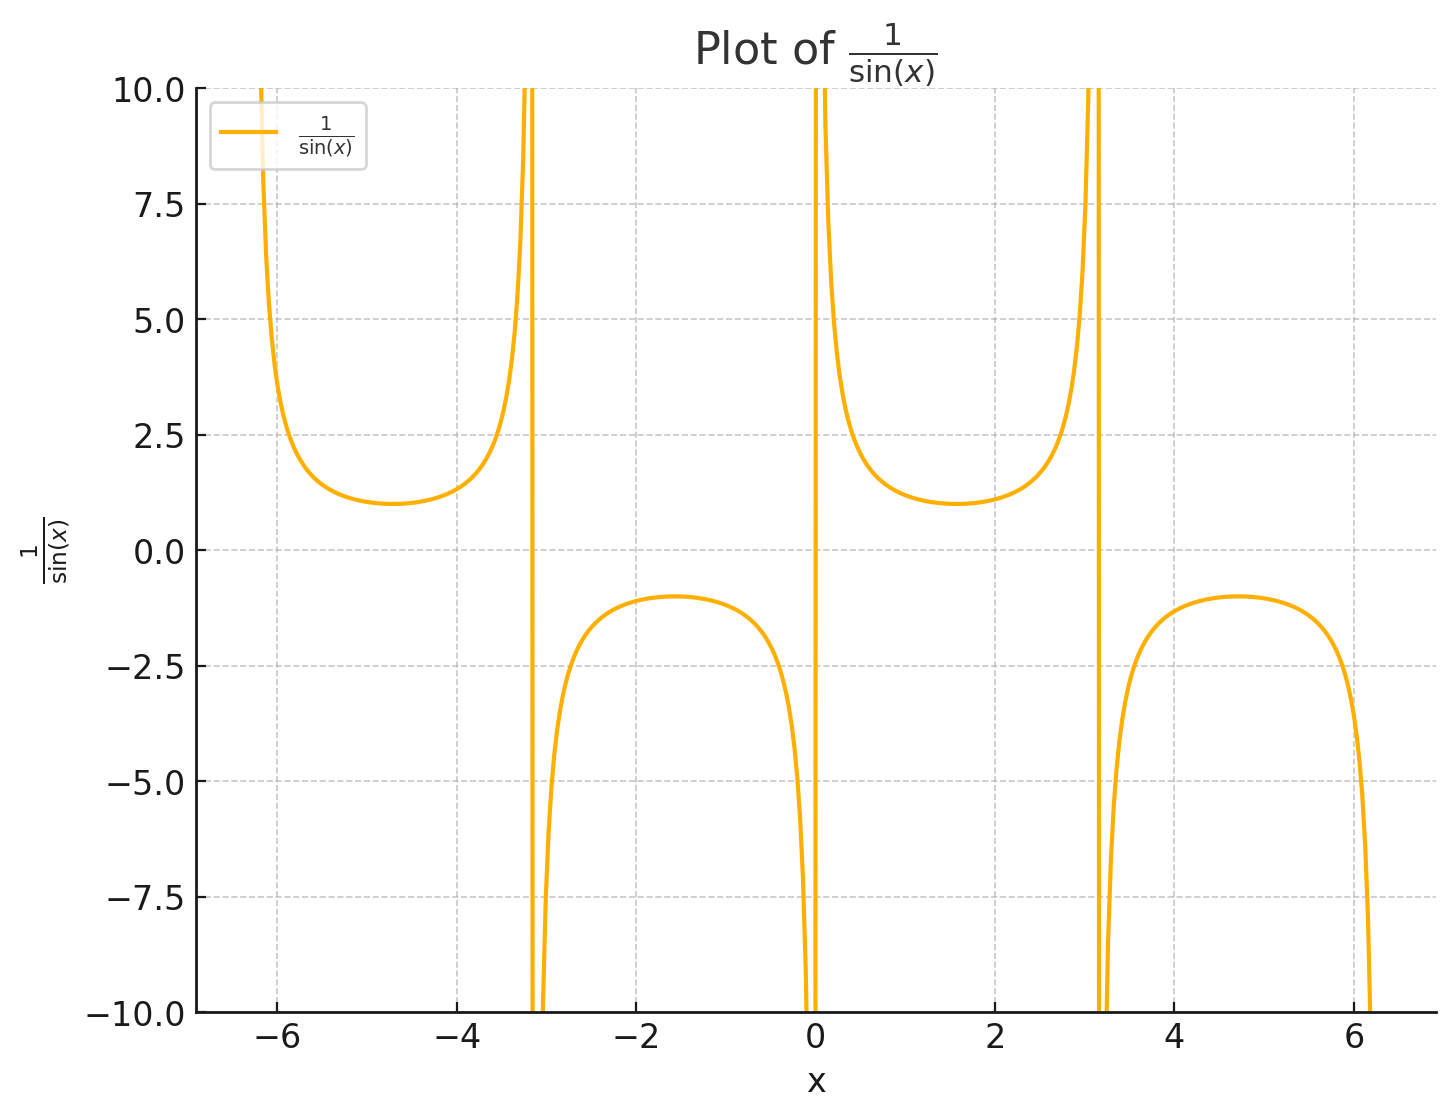

In [52]:
from IPython.display import Image
for c in messages.data[0].content:
    if c.type == 'image_file':
        image_data = client.files.content(c.image_file.file_id)
        image_data_bytes = image_data.read()
        with open(f"./{c.image_file.file_id}.png", "wb") as file:
            file.write(image_data_bytes)
Image(image_data_bytes)

In [53]:
for c in messages.data[0].content:
    if c.type == 'text':
        print(c.text.value)

Here is the plot of the function \(\frac{1}{\sin(x)}\) over the range from \(-2\pi\) to \(2\pi\). I've limited the y-axis to the range \([-10, 10]\) to keep the plot visually informative, especially around values where the sine function approaches zero and the function \(\frac{1}{\sin(x)}\) approaches infinity.


## File search

In [2]:
from openai import OpenAI
 
client = OpenAI()

In [ ]:
# Step 1: Create a new Assistant with File Search Enabled
assistant = client.beta.assistants.create(
  name="Vector search expert",
  instructions="You are an expert about Vector search",
  model="gpt-4-turbo",
  tools=[{"type": "file_search"}],
)

In [56]:
# Step 2: Upload files and add them to a Vector Store
# Create a vector store 
vector_store = client.beta.vector_stores.create(name="Vector search chapter")
file_paths = ["../chap4/Chap 4 - Vector search & Question Answering.pdf"]
file_streams = [open(path, "rb") for path in file_paths]
# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)

# You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)

completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


In [57]:
# Step 3: Update the assistant to to use the new Vector Store
assistant = client.beta.assistants.update(
  assistant_id=assistant.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

In [60]:
# Step 4: Create a thread
# Upload the user provided file to OpenAI
message_file = client.files.create(
  file=open("../chap3/Chap 3 - Chaining & Summarization.pdf", "rb"), purpose="assistants"
)

prompt = "What is the definition of Vector search"
# Create a thread and attach the file to the message
thread = client.beta.threads.create(
  messages=[
    {
      "role": "user",
      "content": prompt,
      # Attach the new file to the message.
      "attachments": [
        { "file_id": message_file.id, "tools": [{"type": "file_search"}] }
      ],
    }
  ]
)
 
# The thread now has a vector store with that file in its tool resources.
print(thread.tool_resources.file_search)

ToolResourcesFileSearch(vector_store_ids=['vs_ulgeT4pn8fzb5wJYebXivJHo'])


In [61]:
# Step 5: Create a run and check the output
# Use the create and poll SDK helper to create a run and poll the status of
# the run until it's in a terminal state.

run = client.beta.threads.runs.create_and_poll(
    thread_id=thread.id, assistant_id=assistant.id
)

messages = list(client.beta.threads.messages.list(thread_id=thread.id, run_id=run.id))

message_content = messages[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

Vector search, also known as semantic search or approximate search, is a search method that uses vector embeddings to represent the content in a multi-dimensional space. This technique allows the system to understand and measure the semantic similarity between queries and documents, rather than relying solely on keyword matching.

In vector search, both the search queries and the items in the database (such as documents, images, or products) are converted into vectors using models like word embeddings or neural networks. The similarity between the query vector and document vectors is then computed using a distance measure such as cosine similarity. Items that are closer to the query vector in this vector space are considered more relevant to the query.

This approach enables more nuanced and context-aware search results because it can capture the underlying meanings and relationships of words and phrases, rather than just their surface representations. Vector search is commonly used in

Retrieve existing assistant and thread to debug `assistant_app.py`.

In [ ]:
# Step 1b: Retrieve an existing Assistant with File Search Enabled
assistant = client.beta.assistants.retrieve("asst_lKH0wC1rCQN1ZnyzGinbYVs3")

In [19]:
assistant

Assistant(id='asst_W7jTBEcOtGhfVB6ua2vtZ9iE', created_at=1716380534, description=None, instructions='You are an expert about Vector search', metadata={}, model='gpt-4-turbo', name='Vector search expert', object='assistant', tools=[FileSearchTool(type='file_search')], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=None, file_search=ToolResourcesFileSearch(vector_store_ids=[])), top_p=1.0)

In [5]:
thread = client.beta.threads.retrieve("thread_j3Qmp3fgeWS86zBaozeO31D0")
thread

Thread(id='thread_j3Qmp3fgeWS86zBaozeO31D0', created_at=1716379786, metadata={}, object='thread', tool_resources=ToolResources(code_interpreter=ToolResourcesCodeInterpreter(file_ids=[]), file_search=None))

In [20]:
thread.tool_resources.file_search

In [6]:
messages = client.beta.threads.messages.list("thread_j3Qmp3fgeWS86zBaozeO31D0")
messages

SyncCursorPage[Message](data=[Message(id='msg_hbXYZVEIMExHxodUjp0Vduds', assistant_id='asst_lKH0wC1rCQN1ZnyzGinbYVs3', attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[FileCitationAnnotation(end_index=121, file_citation=FileCitation(file_id='file-ScLMtcsqDu9cIKjgXGFamkzn', quote=None), start_index=109, text='【4:0†source】', type='file_citation')], value='The vector databases mentioned in the document include Chroma, Pinecone, Weaviate, Faiss, Qdrant, and MongoDB【4:0†source】.'), type='text')], created_at=1716379942, incomplete_at=None, incomplete_details=None, metadata={}, object='thread.message', role='assistant', run_id='run_5hXFe6OAyWFZAa0PmkX6LvMl', status=None, thread_id='thread_j3Qmp3fgeWS86zBaozeO31D0'), Message(id='msg_PrvNF6t42DPTg9VqBbTEXlHn', assistant_id=None, attachments=[], completed_at=None, content=[TextContentBlock(text=Text(annotations=[], value='what are the vector databases mentioned'), type='text')], created_at=1716379936, incomplet

In [7]:
messages.data[0].content[0].text.value

'The vector databases mentioned in the document include Chroma, Pinecone, Weaviate, Faiss, Qdrant, and MongoDB【4:0†source】.'

In [13]:
dict(messages.data[0].content[0].text)

{'annotations': [FileCitationAnnotation(end_index=121, file_citation=FileCitation(file_id='file-ScLMtcsqDu9cIKjgXGFamkzn', quote=None), start_index=109, text='【4:0†source】', type='file_citation')],
 'value': 'The vector databases mentioned in the document include Chroma, Pinecone, Weaviate, Faiss, Qdrant, and MongoDB【4:0†source】.'}

In [16]:
annotations = messages.data[0].content[0].text.annotations
annotations

[FileCitationAnnotation(end_index=121, file_citation=FileCitation(file_id='file-ScLMtcsqDu9cIKjgXGFamkzn', quote=None), start_index=109, text='【4:0†source】', type='file_citation')]

In [ ]:
message_content = messages.data[0].content[0].text
annotations = message_content.annotations
citations = []
for index, annotation in enumerate(annotations):
    message_content.value = message_content.value.replace(annotation.text, f"[{index}]")
    if file_citation := getattr(annotation, "file_citation", None):
        cited_file = client.files.retrieve(file_citation.file_id)
        citations.append(f"[{index}] {cited_file.filename}")

print(message_content.value)
print("\n".join(citations))

The vector databases mentioned in the document include Chroma, Pinecone, Weaviate, Faiss, Qdrant, and MongoDB[0].
[0] Chap 4 - Vector search & Question Answering.pdf


In [18]:
file_id = annotations[0].file_citation.file_id
file_id

'file-ScLMtcsqDu9cIKjgXGFamkzn'

In [25]:
vector_stores = client.beta.vector_stores.list()
vector_stores.data

[VectorStore(id='vs_yyuICOUvFoJtQHi5WJNJVuJB', bytes=None, created_at=1714950563, file_counts=FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1), last_active_at=1716379937, metadata={}, name='Vector search chapter', object='vector_store', status='completed', expires_after=None, expires_at=None, usage_bytes=44422),
 VectorStore(id='vs_UMak5cGPgDxONI81J7BQDjgu', bytes=None, created_at=1710407051, file_counts=FileCounts(cancelled=0, completed=0, failed=0, in_progress=0, total=0), last_active_at=1710407051, metadata={}, name=None, object='vector_store', status='completed', expires_after=None, expires_at=None, usage_bytes=0),
 VectorStore(id='vs_mJis5TOBOV38cU914nc7DqD8', bytes=None, created_at=1709939187, file_counts=FileCounts(cancelled=0, completed=0, failed=0, in_progress=0, total=0), last_active_at=1714927813, metadata={}, name='MATLAB vector store', object='vector_store', status='completed', expires_after=None, expires_at=None, usage_bytes=0)]

In [26]:
vector_store_file = client.beta.vector_stores.files.retrieve(
  vector_store_id="vs_yyuICOUvFoJtQHi5WJNJVuJB",
  file_id=file_id
)
vector_store_file

VectorStoreFile(id='file-ScLMtcsqDu9cIKjgXGFamkzn', created_at=1714950564, last_error=None, object='vector_store.file', status='completed', vector_store_id='vs_yyuICOUvFoJtQHi5WJNJVuJB', usage_bytes=44422)

In [27]:
cited_file = client.files.retrieve(file_id)
cited_file

FileObject(id='file-ScLMtcsqDu9cIKjgXGFamkzn', bytes=1057935, created_at=1714950564, filename='Chap 4 - Vector search & Question Answering.pdf', object='file', purpose='assistants', status='processed', status_details=None)